In [1]:
import time
import skimage
from skimage.measure import block_reduce

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
import parc.data.data_em as data
#from parc import misc, metrics, visualization
from parc.model import model_em as model

2024-06-24 12:42:28.941916: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:42:33.510754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78699 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


In [18]:
# read in data
state_path = "/scratch/pdy2bw/class5_mesoscale_processed/mesoscale_x.npy"
vel_path = "/scratch/pdy2bw/class5_mesoscale_processed/mesoscale_u.npy"

state_seq_whole = np.float32(np.load(state_path))
vel_seq_whole = np.float32(np.load(vel_path))

In [21]:
# Calculate the amount of padding needed
target_height = 192
padding_needed = target_height - state_seq_whole.shape[1]

# Calculate padding for the height dimension
padding_top = padding_needed // 2
padding_bottom = padding_needed - padding_top

# Define the padding configuration
paddings = [[0, 0], [padding_top, padding_bottom], [0, 0], [0, 0]]

# Apply padding
state_seq_whole = np.pad(state_seq_whole, paddings, mode='constant', constant_values=0)
vel_seq_whole = np.pad(vel_seq_whole, paddings, mode='constant', constant_values=0)

In [25]:
# normalize
state_seq_norm = data.data_normalization(state_seq_whole,3)
vel_seq_norm = data.data_normalization(vel_seq_whole,2)

In [26]:
# TRAINING

# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,:3],vel_seq_norm[0][:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,-3:],vel_seq_norm[0][:,:,:,-2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(4) # changed to 4 from 8 because data too big for 8

In [27]:
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "rk4", mode = "differentiator_training")
# parc.differentiator.load_weights('class5_mse_1200epoch.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 10, shuffle = True)

Epoch 1/10


2024-06-24 12:53:44.729341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-06-24 12:53:50.931781: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa92e386ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-24 12:53:50.931813: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-06-24 12:53:51.054586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-24 12:53:51.845581: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - 150s 854ms/step - total_loss: 313.2054
Epoch 2/10
120/120 [==============================] - 103s 854ms/step - total_loss: 213.0837
Epoch 3/10
120/120 [==============================] - 102s 853ms/step - total_loss: 112.0613
Epoch 5/10
120/120 [==============================] - 103s 855ms/step - total_loss: 100.0847
Epoch 6/10
120/120 [==============================] - 103s 856ms/step - total_loss: 89.8260
Epoch 7/10
120/120 [==============================] - 102s 853ms/step - total_loss: 82.8845
Epoch 8/10
120/120 [==============================] - 102s 854ms/step - total_loss: 77.1554
Epoch 9/10
120/120 [==============================] - 103s 855ms/step - total_loss: 72.5538
Epoch 10/10
120/120 [==============================] - 103s 854ms/step - total_loss: 68.3909


In [28]:
parc.differentiator.save_weights('lassen_test_weights.h5')

In [29]:
# Validation

# Load Weights
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 14, step_size= 1/15, solver = "rk4")
parc_rk.compile()
parc_rk.differentiator.load_weights('lassen_test_weights.h5')

In [30]:
idx = 0
state_var_init = tf.cast(state_seq_norm[0][idx:idx+1,:,:,:3], tf.float32)
velocity_init = tf.cast(vel_seq_norm[0][idx:idx+1,:,:,:2], tf.float32)
input_seq_current = tf.concat([state_var_init, velocity_init],axis = -1)

state_whole = []
vel_whole = []
for ts in range(30):
    input_seq_current, update = parc_rk.explicit_update(input_seq_current)
    state_whole.append(input_seq_current[:,:,:,:3])
    vel_whole.append(input_seq_current[:,:,:,3:])
state_pred = tf.concat(state_whole, axis = -1).numpy()
vel_pred = tf.concat(vel_whole, axis = -1).numpy()

2024-06-24 13:15:51.780269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


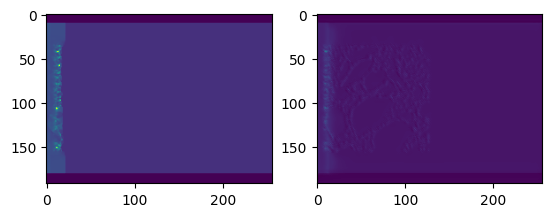

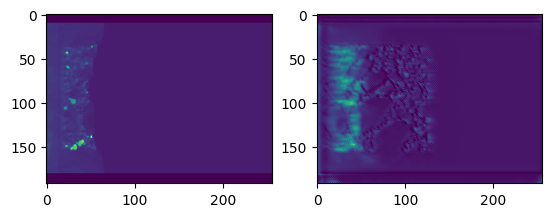

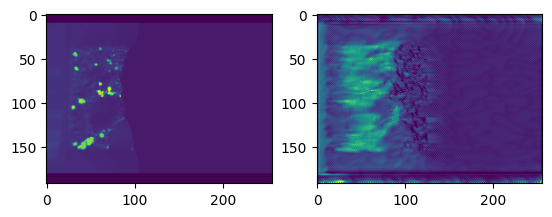

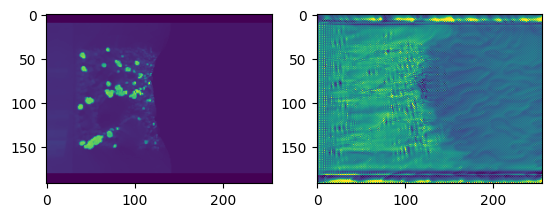

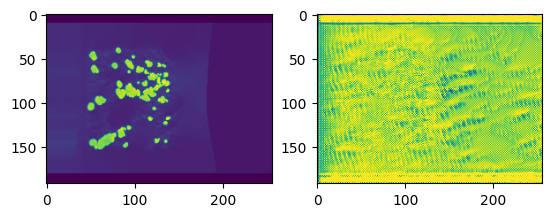

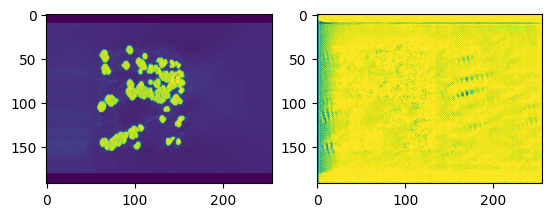

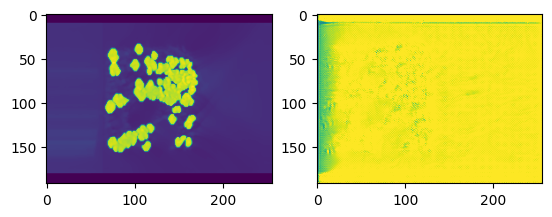

In [31]:
for i in range(30):
    fig, ax = plt.subplots(1,2) # switch to (1,2) for horizontal
    ax[0].imshow(state_seq_whole[i+idx, :, :, 3])
    ax[1].imshow(state_pred[0, :, :, i * 3], vmin=0, vmax=1)
    if i % 5 == 0 or i == 29:
        # plt.savefig(f'train_class5_2_1400epoch{i}.png')
        plt.show()
    plt.close(fig)  # Close the figure after each iteration to free memory
